In [1]:
#plotting and printing
from __future__ import print_function
from matplotlib import pyplot as plt

#machine learning packages
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.utils import shuffle

#other packages
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

#file management
import glob
import os

#database information
from datetime import date
from peewee import *
import uuid

# Settings

In [2]:
#For now, you can log in to Maartje's username. Later, this should be changed to separate users.\n",
name = 'maartjehuveneers'
pw = 'p4RwxJCchw7Ljqhv'

#Settings for the experiment
SETTINGS = "First time running the experiment, Neural Network with ..."

# Database setup

In [22]:
#Setting up database
db = MySQLDatabase('HorsingAround', user=name, password=pw,
                         host='www.jacobkamminga.nl', port=3306)

class Experiment(Model):
    key = UUIDField()
    username = TextField()
    horse = TextField()
    date = DateField()
    accuracy_experiment = DoubleField()
    fscore = DoubleField()
    mcc = DoubleField()
    recall = DoubleField()
    settings = TextField()
    class Meta:
        database = db

class Activity(Model):
    key = UUIDField()
    horse = TextField()
    activity = TextField()
    accuracy_activity = DoubleField()
    recall = DoubleField()
    specificity = DoubleField()
    precision = DoubleField()
    TP = IntegerField()
    TN = IntegerField()
    FP = IntegerField()
    FN = IntegerField()
    class Meta:
        database = db

db.connect()

True

In [4]:
#The next lines are used to create a new table in the database, don't uncomment this unless needed. Otherwise we make a new table every time we run the program

# db.create_tables([Experiment, Activity])

# Labels and Settings

In [5]:
#Some styling
pd.options.display.float_format = '{:.1f}'.format
sns.set()
plt.style.use('ggplot')

#Label encoder used to get a numeric representation of a label
le = preprocessing.LabelEncoder()

#The activities
LABELS = ['standing',
          'walking-natural',
          'walking-rider',
          'trotting-natural',
          'trotting-rider',
          'running-natural',
          'running-rider',
          'jumping',
          'grazing',
          'eating',
          'head shake',
          'shaking',
          'scratch-biting',
          'rubbing',
          'fighting',
          'rolling',
          'scared']

#Sliding windows
TIME_PERIODS = 200
STEP_DISTANCE = 100

#Datasets
FILES = sorted(glob.glob('Data/*'))

# Set up dataframe

In [6]:
REMOVE_COLUMNS = ['Mx', 'My', 'Mz','A3D','G3D','M3D'] #Add columns to drop from dataframe

def loadDataFrame(files):
    """
    Simple function to set up dataframe and initial clean-up of the data
    files: path to files
    returns: combined dataframe of all files
    """
    df = pd.DataFrame()
    for file in files:
        csv = pd.read_csv(file)
        csv['filename']=file
        df = df.append(csv)
        
    df.drop(REMOVE_COLUMNS, axis=1, inplace=True)
    df['ActivityEncoded'] = le.fit_transform(df['label'].values.ravel())

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan


df = loadDataFrame(FILES)

# Plot data composition

In [7]:
# def show_basic_dataframe_info(dataframe):

#     # Shape and how many rows and columns
#     print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
#     print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

# show_basic_dataframe_info(df)
# df.head(20)

In [8]:
#Plotting activity data

#Training examples per activity type
# SECONDS = 10 #nr of seconds to display accelerometer data
# SAMPLING_RATE = 20 #the sampling rate at which data was recorded

# def plot_activity(activity, data):
#     fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
#     l1, = ax[0].plot(data['datetime'], data['Ax'], label="X-axis")
#     l2, = ax[0].plot(data['datetime'], data['Ay'], label="Y-Axis")
#     l3, = ax[0].plot(data['datetime'], data['Az'], label="Z-Axis")
#     ax[0].set_ylabel('Accelerometer measurement')
#     ax[0].set_xlabel('Time')
#     ax[0].legend(handles=[l1,l2,l3], loc='lower right')
#     ax[0].xaxis.set_ticks([])
#     ax[0].set_title(activity+" accelerometer data")
#     ax[0].grid(False)
    
#     l1, = ax[1].plot(data['datetime'], data['Gx'], label="X-axis")
#     l2, = ax[1].plot(data['datetime'], data['Gy'], label="Y-Axis")
#     l3, = ax[1].plot(data['datetime'], data['Gz'], label="Z-Axis")
#     ax[1].set_ylabel('Gyroscope measurement')
#     ax[1].set_xlabel('Time')
#     ax[1].legend(handles=[l1,l2,l3], loc='lower right')
#     ax[1].xaxis.set_ticks([])
#     ax[1].set_title(activity+" gyroscope data")
#     ax[1].grid(False)
    
#     plt.show()

# #plot all 3 subplots for each activity
# for activity in np.unique(df['label']):
#     subset = df[df['label'] == activity][:SECONDS*SAMPLING_RATE] 
#     plot_activity(activity, subset)

# Encoding the labels to integers

In [9]:
# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['label'].values.ravel())

# Get only relevant subjects

In [10]:
#These are the indexes of the relevant subjects, see FILES
indexes = [0,1,2,7,8,9,13,14,15,16,17]
subjects = [FILES[x] for x in indexes]

#new dataframe with only the horses in subjects
df = df[df['filename'].isin(subjects)]

#Might need to add Viva later on again?
subject_names = ['Galoway', 'Patron', 'Happy', 'Driekus']

# Splitting in test and train

In [11]:
'''
  Function to split train and test data by subject
  df = dataframe
  name = subject to put in test subset
  '''
def splitBySubject(name):
    print(name)
    test = df[df['filename'].str.contains(name)]
    train = df[~df['filename'].str.contains(name)]
    return train, test

# Feature scaling

In [12]:
def featureScaling(data):
    train_x_max = data['Ax'].max()
    train_y_max = data['Ay'].max()
    train_z_max = data['Az'].max()

    train_gx_max = data['Gx'].max()
    train_gy_max = data['Gy'].max()
    train_gz_max = data['Gz'].max()

    pd.options.mode.chained_assignment = None

    #divide all 3 axis with the max value in the training set
    data['Ax'] = data['Ax'] / train_x_max
    data['Ay'] = data['Ay'] / train_y_max
    data['Az'] = data['Az'] / train_z_max

    data['Gx'] = data['Ax'] / train_gx_max
    data['Gy'] = data['Ay'] / train_gy_max
    data['Gz'] = data['Az'] / train_gz_max

    data = data.round({'Ax': 4, 'Ay': 4, 'Az': 4, 'Gx':4, 'Gy':4, 'Gz':4})
    return data

# Windowing

In [13]:
def createWindows(df, time_steps, step, label_name):
    N_FEATURES = 6
    windows = []
    labels = []
    for i in range(0, len(df)-time_steps, step):
        axs = df['Ax'].values[i: i + time_steps]
        ays = df['Ay'].values[i: i + time_steps]
        azs = df['Az'].values[i: i + time_steps]

        gxs = df['Gx'].values[i: i + time_steps]
        gys = df['Gy'].values[i: i + time_steps]
        gzs = df['Gz'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        windows.append([axs, ays, azs, gxs, gys, gzs])
        labels.append(label)
    # Bring the segments into a better shape
    reshaped_windows = np.asarray(windows, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_windows, labels

# Reshaping data

In [14]:
# reshaping one dimentional xtrain into fitted data for the classifier
def inputShape(data):
    data = data.reshape(data.shape[0], input_shape)
    return data

# OneHotCoding the labels

In [15]:
# Applying one hot coding to y_train
def oneHotCoding(data):
    y_train_hot = np_utils.to_categorical(data, num_classes)
    return y_train_hot

# Classifier

In [16]:
def classifierModel():
    model_m = Sequential()
    # Remark: since coreml cannot accept vector shapes of complex shape like
    # [80,3] this workaround is used in order to reshape the vector internally
    # prior feeding it into the network
    model_m.add(Reshape((TIME_PERIODS, 6), input_shape=(input_shape,)))
    model_m.add(Dense(100, activation='relu'))
    model_m.add(Dense(100, activation='relu'))
    model_m.add(Dense(100, activation='relu'))
    model_m.add(Flatten())
    model_m.add(Dense(num_classes, activation='softmax'))
    return model_m

In [17]:
# takes x_train and y_train_hot
def classifier(xdata, ydata):
    modelm = classifierModel()

    callbacks_list = [
        keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
    ]

    modelm.compile(loss='categorical_crossentropy',
                    optimizer='adam', metrics=['accuracy'])

    # Hyper-parameters
    BATCH_SIZE = 600
    EPOCHS = 2

    # Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
    history = modelm.fit(xdata,
                          ydata,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          callbacks=callbacks_list,
                          validation_split=0.2,
                          verbose=1)
    return history, modelm

In [18]:
#printing the evaluation results of the train dataset
def printResults(history, modelm, x_train, y_train):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
    plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
    plt.plot(history.history['loss'], 'r--', label='Loss of training data')
    plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()

    # Print confusion matrix for training data
    y_pred_train = modelm.predict(x_train)
    # Take the class with the highest probability from the train predictions
    max_y_pred_train = np.argmax(y_pred_train, axis=1)
    print(classification_report(y_train, max_y_pred_train))

In [19]:
#printing the evaluation results of the test dataset
def testValidation(test, modelm):
    # Normalize features for training data set
    test['Ax'] = test['Ax'] / test['Ax'].max()
    test['Ay'] = test['Ay'] / test['Ay'].max()
    test['Az'] = test['Az'] / test['Az'].max()

    test['Gx'] = test['Gx'] / test['Gx'].max()
    test['Gy'] = test['Gy'] / test['Gy'].max()
    test['Gz'] = test['Gz'] / test['Gz'].max()

    df_test = test.round({'Ax': 4, 'Ay': 4, 'Az': 4, 'Gx':4, 'Gy':4, 'Gz':4})

    x_test, y_test = createWindows(df_test,
                                   TIME_PERIODS,
                                   STEP_DISTANCE,
                                   LABEL)
    
    # Set input_shape / reshape for Keras
    x_test = x_test.reshape(x_test.shape[0], input_shape)

    x_test = x_test.astype('float32')
    y_test = y_test.astype('float32')

    y_test = np_utils.to_categorical(y_test, num_classes)
    score = modelm.evaluate(x_test, y_test, verbose=1)
    
    print('\nAccuracy on test data: %0.2f' % score[1])
    return x_test, y_test, score[1]

In [26]:
def show_confusion_matrix(validations, predictions, model_m):
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    y_pred_test = model_m.predict(x_test)
    # Take the class with the highest probability from the test predictions
    max_y_pred_test = np.argmax(y_pred_test, axis=1)
    max_y_test = np.argmax(y_test, axis=1)

    
    precision_per_class, recall_per_class, f_score_per_class, _ = metrics.precision_recall_fscore_support(max_y_test, max_y_pred_test, zero_division=0)
    _, recall_avg, f_score_avg, _ = metrics.precision_recall_fscore_support(max_y_test, max_y_pred_test, pos_label=None, average="weighted", zero_division=0)
    
    mcc = metrics.matthews_corrcoef(max_y_test, max_y_pred_test)
    
    #print(classification_report(max_y_test, max_y_pred_test, output_dict=True))
    return matrix, precision_per_class, recall_per_class, f_score_per_class, recall_avg, f_score_avg, mcc

In [23]:
query = Experiment.select().dicts()
for q in query:
    print(q)

query = Activity.select().dicts()
for q in query:
    print(q)

{'id': 1, 'key': UUID('616453bd-ee63-4c2c-8e70-96e8074dd9a5'), 'username': 'maartjehuveneers', 'horse': 'Galoway', 'date': datetime.date(2021, 5, 3), 'accuracy_experiment': 0.7930938005447388, 'fscore': 0.7901676450101861, 'mcc': 0.7275470824924013, 'recall': 0.7930937773882559, 'settings': 'First test with running the experiment'}
{'id': 2, 'key': UUID('b4765c5c-7008-4db4-b4f7-a99c290dd20d'), 'username': 'maartjehuveneers', 'horse': 'Galoway', 'date': datetime.date(2021, 5, 3), 'accuracy_experiment': 0.7256792187690735, 'fscore': 0.7221669664764988, 'mcc': 0.6485635019518886, 'recall': 0.7256792287467134, 'settings': 'First time running the experiment, Neural Network with ...'}
{'id': 3, 'key': UUID('b4765c5c-7008-4db4-b4f7-a99c290dd20d'), 'username': 'maartjehuveneers', 'horse': 'Patron', 'date': datetime.date(2021, 5, 3), 'accuracy_experiment': 0.8151192665100098, 'fscore': 0.8200997873075356, 'mcc': 0.7546106432806079, 'recall': 0.8151192561649373, 'settings': 'First time running t

In [24]:
#searching for an experiment and printing its results
#insert experiment key below as variable
experiment_key = "616453bd-ee63-4c2c-8e70-96e8074dd9a5"

query = Experiment.select().where(Experiment.key == experiment_key).dicts()
for exp in query:
    print(exp)
    
query = Activity.select().where(Activity.key == experiment_key).dicts()
for exp in query:
    print(exp)
    

#selecting queries based on date
query = Experiment.select().where(Experiment.date.day == 3, Experiment.date.month == 5).dicts()
for exp in query:
    print(exp)

{'id': 1, 'key': UUID('616453bd-ee63-4c2c-8e70-96e8074dd9a5'), 'username': 'maartjehuveneers', 'horse': 'Galoway', 'date': datetime.date(2021, 5, 3), 'accuracy_experiment': 0.7930938005447388, 'fscore': 0.7901676450101861, 'mcc': 0.7275470824924013, 'recall': 0.7930937773882559, 'settings': 'First test with running the experiment'}
{'id': 1, 'key': UUID('616453bd-ee63-4c2c-8e70-96e8074dd9a5'), 'horse': 'Galoway', 'activity': 'standing', 'accuracy_activity': 0.9993689745836986, 'recall': 0.0, 'specificity': 1.0, 'precision': 0.0, 'TP': 0, 'TN': 28507, 'FP': 0, 'FN': 18}
{'id': 2, 'key': UUID('616453bd-ee63-4c2c-8e70-96e8074dd9a5'), 'horse': 'Galoway', 'activity': 'walking-natural', 'accuracy_activity': 0.9988781770376862, 'recall': 0.0, 'specificity': 1.0, 'precision': 0.0, 'TP': 0, 'TN': 28493, 'FP': 0, 'FN': 32}
{'id': 3, 'key': UUID('616453bd-ee63-4c2c-8e70-96e8074dd9a5'), 'horse': 'Galoway', 'activity': 'walking-rider', 'accuracy_activity': 0.9590885188431201, 'recall': 0.828125, 's

# Loop of training with all subjects

Galoway
Epoch 1/2
81/81 [==============================] - 6s 57ms/step - loss: 1.5054 - accuracy: 0.5507 - val_loss: 0.4178 - val_accuracy: 0.8884
Epoch 2/2
892/892 [==============================] - 8s 9ms/step - loss: 0.9927 - accuracy: 0.7295

Accuracy on test data: 0.73


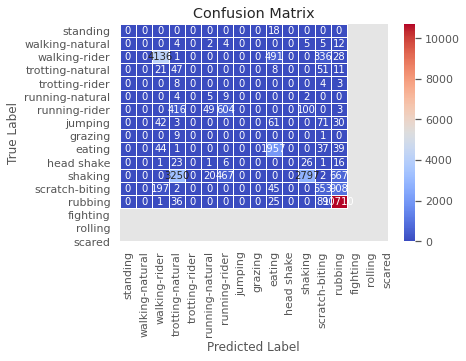

Patron
Epoch 1/2
99/99 [==============================] - 7s 55ms/step - loss: 1.4217 - accuracy: 0.5934 - val_loss: 0.4099 - val_accuracy: 0.8933
Epoch 2/2
377/464 [=======================>......] - ETA: 0s - loss: 0.7168 - accuracy: 0.8141

KeyboardInterrupt: 

In [27]:
uid = uuid.uuid4()

for i in subject_names:
    train, test = splitBySubject(i) #splitting the data into test and train datasets
    train = featureScaling(train) #feature scaling the train dataset
    x_train, y_train = createWindows(train, #windowing the train dataset. Returns the data (x_train) and labels (y_train).
                                     TIME_PERIODS, 
                                     STEP_DISTANCE, 
                                     LABEL)
    x_train, y_train = shuffle(np.array(x_train), np.array(y_train)) #shuffling the train data
    num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
    num_classes = le.classes_.size
    input_shape = (num_time_periods*num_sensors)
    x_train = inputShape(x_train)
    x_train = x_train.astype('float32')
    y_train = y_train.astype('float32')
    y_train_hot = oneHotCoding(y_train) #encode label Strings to integers
    history, modelm = classifier(x_train, y_train_hot) #training the model
    #printResults(history, modelm, x_train, y_train) #retrieving and printing the performance results of the training data
    x_test, y_test, acc = testValidation(test, modelm)
    y_pred_test = modelm.predict(x_test)
    
    # Take the class with the highest probability from the test predictions
    max_y_pred_test = np.argmax(y_pred_test, axis=1)
    max_y_test = np.argmax(y_test, axis=1)
    
    matrix, precision_per_class, recall_per_class, f_score_per_class, recall_avg, f_score_avg, mcc_score = show_confusion_matrix(max_y_test, max_y_pred_test, modelm) #print confusion matrix and get evaluation results of the test data
    Experiment.create(key=uid, username=name, horse=i, date=date.today(), accuracy_experiment=acc, fscore=f_score_avg, mcc=mcc_score, recall=recall_avg, settings=SETTINGS) #save results per horse on database
    
    for act in LABELS:
        index = LABELS.index(act)
        if(index >= len(matrix)): #activity contains no data
            break
        TP = matrix[index][index]
        FN = matrix[index].sum() - TP
        FP = 0
        for j in range(0, len(matrix)):
            FP += matrix[j][index]
        FP = FP - TP
        TN = matrix.sum() - TP - FN - FP
        accuracy = (TP+TN)/(TP+TN+FP+FN)
        specificity = TN/(TN+FP)
        #save results per activity per horse in the database
        Activity.create(key=uid, horse=i, activity=act, accuracy_activity=accuracy, recall=recall_per_class[index], specificity=specificity, precision=precision_per_class[index], TP=TP, TN=TN, FP=FP, FN=FN)